# 第7章 畳み込みニューラルネットワーク（CNN）

# 前提

In [2]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加
from deep_learning_from_scratch.common.functions import *
from deep_learning_from_scratch.common.gradient import numerical_gradient  # 勾配を計算する関数

import numpy as np
from collections import OrderedDict  # 順序付き辞書を使用, 追加した要素の順序を覚えることが可能


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx
    
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

class Adam:
    """Adam (http://arxiv.org/abs/1412.6980v8)"""
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        """
        初期化
        lr: 学習率(Learning Rate)
        beta1: 一次モーメントの指数移動平均の係数（標準設定値：0.9）
        beta2: 二次モーメントの指数移動平均の係数（標準設定値：0.999）
        betaはバイアス補正のための係数
        """
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

# 全体構造

- **畳み込みニューラルネットワーク**（以下CNN）
    - 従来通りいくつかのレイヤを組み合わせて作成
    - 新たに登場するレイヤ：
        - **Convolutionレイヤ（畳み込み層）**
        - **Poolingレイヤ（プーリング層）**
- これまでとの比較
    - これまでのニューラルネットワーク
        - 隣接する層のすべてのニューロン間で結合していた（全結合, Affineレイヤ）
        - 全結合のニューラルネットワーク：
            - Affineレイヤの後に活性化関数のレイヤ（ReLUやSigmoid）をくっつける
            - [Affine-活性化関数]の組み合わせを4層重ね、5層目のAffineレイヤと続き、最後にsoftmaxレイヤで最終的な確率を出力
    - CNN
        - ConvolutionレイヤとPoolingレイヤを追加
        - [Convolution-活性化関数-(Pooling)]という流れでつながる
            - Poolingレイヤは省略されることがある 
        - 出力層に近い層では、[Affine-活性化関数]という組み合わせが用いられる
        - 最終の出力層においては、これまで通り[Affine-Softmax]の組み合わせが用いられる
        - 参考画像([参照](https://thinkit.co.jp/sites/default/files/639906.png))  
        ![CNNの画像](https://thinkit.co.jp/sites/default/files/639906.png)

# 畳み込み層

## 全結合層の問題点
> **全結合層**  
> 隣接する層のニューロンがすべて連結されており、出力の数は任意に決めることができる
- 問題点：
    - データ形状が「**無視**」されてしまう
    - Ex）
        - 入力データ：画像（チャンネル数・縦・横の3次元方向）
        - 全結合層に入力するときには、3次元のデータを1次元のデータにする必要がある
        - MNISTデータセットでは、(28, 28, 1)の入力画像を一列に並べた784個をAffineレイヤに入力する
    - 画像は3次元形状であり、大切な空間情報が含まれている
        - 空間的に近いピクセルは似たような値
        - RBGの各チャンネル間には密接な関係正がある
        - 全結合はこれらの大切な情報を完全に無視してしまう
- CNN：
    - **形状を維持する**
    - 画像の場合：
        - 入力データ：3次元データ
        - 次の層：3次元データを出力
    - 画像などの形状を有したデータを正しく理解できる可能性がある
- CNNの用語
    > **特徴マップ（feature map）**：畳み込み層の入出力データ  
    > **入力特徴マップ（input feature map）**：畳み込み層の入力データ  
    > **出力特徴マップ（output feature map0）**：畳み込み層の出力データ
    

## 畳み込み演算
- 畳み込み層で行う処理＝「畳み込み演算」
- 畳み込み演算＝画像でいうところの**フィルター処理**

In [3]:
import numpy as np

input_data = np.array([
    [1, 2, 3, 0],
    [0, 1, 2, 3],
    [3, 0, 1, 2],
    [2, 3, 0, 1],
])

filter_data = np.array([
    [2, 0, 1],
    [0, 1, 2],
    [1, 0, 2],
])

- 上のコードのように、入力データにフィルターデータを適用する
    - 入力データ：縦・横の形状をもつデータ
    - フィルターデータ：縦・横の形状をもつデータ
- 形状を（height, width）とすると...
    - 入力サイズ：（4, 4）
    - フィルターサイズ(カーネル)：(3, 3)
    - 出力サイズ：（2, 2）

In [4]:
def convolve2d(input_data, filter_data):
    """
    入力データとフィルタを2次元畳み込みする関数
    :param input_data: 2次元の入力データ
    :param filter_data: 2次元のフィルタデータ
    :return: 畳み込み結果の2次元配列
    """
    input_height, input_width = input_data.shape  # 入力データの高さと幅を取得
    filter_height, filter_width = filter_data.shape  # フィルタの高さと幅を取得
    output_height = input_height - filter_height + 1  # 出力の高さを計算
    output_width = input_width - filter_width + 1  # 出力の幅を計算
    output_data = np.zeros((output_height, output_width))  # 出力データの初期化

    for i in range(output_height):
        for j in range(output_width):  
            region = input_data[i:i + filter_height, j:j + filter_width]  # 入力データの対応する領域を取得
            output_data[i, j] = np.sum(region * filter_data)  # フィルタと領域の要素ごとの積の和を計算

    return output_data

output_data = convolve2d(input_data, filter_data)
print(output_data)

[[15. 16.]
 [ 6. 15.]]


- 畳み込み演算：
    - 入力データに対して、フィルターのウィンドウを一定の感覚でスライドさせて適用
        - ウィンドウ：フィルターの縦×横の四角形のこと
    - 入力データのそれぞれのウィンドウ範囲で要素を乗算し、その和を求める
        - **積和演算**と呼ぶ
        - 上のコードの`output_data[i, j] = np.sum(region * filter_data)`の部分
    - このプロセスをすべての場所で行うことで、畳み込み演算の出力を得ることが可能

- CNNの「重み」に関して
    - 全結合ニューラルネットワーク：重みパラメータの他にバイアスが存在
    - CNN：
        - 重み＝フィルターのパラメータに該当
        - CNNにはバイアスが存在する
            - バイアス項の加算は、フィルター適用後のデータに対して行う
            - バイアスは1 x 1だけ存在
            - その1つのバイアスがフィルター適用後のすべての要素に加算される

In [5]:
def add_bias(output_data, bias):
    """
    畳み込み結果にバイアスを加える関数
    :param output_data: 2次元の畳み込み結果
    :param bias: 加えるバイアス値
    :return: バイアスを加えた2次元配列
    """
    return output_data + bias

bias = 3  # バイアス値の設定
output_data_with_bias = add_bias(output_data, bias)
print(output_data_with_bias)

[[18. 19.]
 [ 9. 18.]]


## パディング
> **パティング**  
> 畳み込み層の処理を行う前に、入力データの周囲に固定データを埋めること  
> 出力サイズを調整するために存在  
> 調整を行わないと、いつか出力データのサイズは1になってしまう（これを防ぐために必要）
- 以下のコードでは、input dataの周囲を0に埋めている
    - これにより`4x4`だった入力データはパティングによって`6x6`の形状になった
    - これに`3x3`フィルターをかけると、`4x4`サイズの出力データが生成
- この例では、パティングを`1`に設定
    - パティングの値は2, 3など任意の整数に設定できる
    - もしパティングが2なら入力データは`8x8`、3なら入力データは`10x10`になる

In [6]:
def make_padding_data(input_data, padding_size):
    """
    入力データにパディングを追加する関数
    :param input_data: 2次元の入力データ
    :param padding_size: パディングのサイズ（上下左右）
    :return: パディングされた2次元配列
    """
    padded_data = np.zeros((input_data.shape[0] + 2 * padding_size, input_data.shape[1] + 2 * padding_size))
    padded_data[padding_size:-padding_size, padding_size:-padding_size] = input_data
    return padded_data

for i in range(1, 4):
    padding_size = i  # パディングのサイズを1に設定
    padding_data = make_padding_data(input_data, padding_size)
    print(f"パディング{i}処理後の入力データ：サイズ{padding_data.shape}")
    if padding_size == 1:
        print(padding_data)

    # パディング後の入力データに対して再度畳み込みを行う
    output_data_padded = convolve2d(padding_data, filter_data)
    print(f"パディング{i}の畳み込み結果：サイズ{output_data_padded.shape}")
    if padding_size == 1:
        print(output_data_padded)
    print()

パディング1処理後の入力データ：サイズ(6, 6)
[[0. 0. 0. 0. 0. 0.]
 [0. 1. 2. 3. 0. 0.]
 [0. 0. 1. 2. 3. 0.]
 [0. 3. 0. 1. 2. 0.]
 [0. 2. 3. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]
パディング1の畳み込み結果：サイズ(4, 4)
[[ 7. 12. 10.  2.]
 [ 4. 15. 16. 10.]
 [10.  6. 15.  6.]
 [ 8. 10.  4.  3.]]

パディング2処理後の入力データ：サイズ(8, 8)
パディング2の畳み込み結果：サイズ(6, 6)

パディング3処理後の入力データ：サイズ(10, 10)
パディング3の畳み込み結果：サイズ(8, 8)



## ストライド
> **ストライド**  
> フィルターを適用する位置の間隔
- これまでの例ではストライドは`1`
- `2`に設定すると、フィルターを適用するウィンドウの間隔が2要素ごとになる
- Ex)
    - 入力データ：7x7のサイズ
    - ストライド：2
    - 出力データ：3x3のサイズ
- **ストライドを大きく**すると、**出力サイズは小さく**なる
- **ストライドを小さく**すると、**出力サイズは大きく**なる

In [7]:
input_data = np.array([
    [1, 2, 3, 0, 1, 2, 3],
    [0, 1, 2, 3, 0, 1, 2],
    [3, 0, 1, 2, 3, 0, 1],
    [2, 3, 0, 1, 2, 3, 0],
    [1, 2, 3, 0, 1, 2, 3],
    [0, 1, 2, 3, 0, 1, 2],
    [3, 0, 1, 2, 3, 0, 1],
])

filter_data = np.array([
    [2, 0, 1],
    [0, 1, 2],
    [1, 0, 2],
])

def convolve2d_with_stride(input_data, filter_data, stride):
    """
    入力データとフィルタをストライドを考慮して2次元畳み込みする関数
    :param input_data: 2次元の入力データ
    :param filter_data: 2次元のフィルタデータ
    :param stride: ストライドのサイズ
    :return: 畳み込み結果の2次元配列
    """
    input_height, input_width = input_data.shape
    filter_height, filter_width = filter_data.shape
    output_height = (input_height - filter_height) // stride + 1
    output_width = (input_width - filter_width) // stride + 1
    output_data = np.zeros((output_height, output_width))

    for i in range(output_height):
        for j in range(output_width):
            region = input_data[i * stride:i * stride + filter_height, j * stride:j * stride + filter_width]
            output_data[i, j] = np.sum(region * filter_data)

    return output_data

for i in range(1, 4):
    stride = i  # ストライドの設定
    output_data_stride = convolve2d_with_stride(input_data, filter_data, stride)
    print(f"ストライド{stride}の畳み込み結果：サイズ{output_data_stride.shape}")
    print(output_data_stride)

ストライド1の畳み込み結果：サイズ(5, 5)
[[15. 16. 17.  6. 15.]
 [ 6. 15. 16. 17.  6.]
 [17.  6. 15. 16. 17.]
 [16. 17.  6. 15. 16.]
 [15. 16. 17.  6. 15.]]
ストライド2の畳み込み結果：サイズ(3, 3)
[[15. 17. 15.]
 [17. 15. 17.]
 [15. 17. 15.]]
ストライド3の畳み込み結果：サイズ(2, 2)
[[15.  6.]
 [16. 15.]]


- これまでの関係性を定式化してみる
    $$OH = \frac{H+2P-FH}{S}+1$$
    $$OW = \frac{W+2P-FH}{S}+1$$
    - 入力サイズ： $(H, W)$
    - フィルターサイズ： $(FH, FW)$
    - 出力サイズ： $(OH, OW)$
    - パティング： $P$
    - ストライド： $S$
    > 注意：  
    > この式が**割り切れるようにそれぞれの値を設定する**必要がある！（小数の場合はエラーが発生することがある）
- 例）
    $$OH = \frac{4+2×1-2}{2}+1=3$$
    $$OW = \frac{4+2×1-2}{2}+1=3$$
    - 入力サイズ： $(4, 4)$
    - フィルターサイズ： $(3, 3)$
    - 出力サイズ： $(OH, OW)$
    - パティング： $1$
    - ストライド： $2$

In [8]:
input_data = np.array([
    [1, 2, 3, 0],
    [0, 1, 2, 3],
    [3, 0, 1, 2],
    [2, 3, 0, 1],
])

filter_data = np.array([
    [2, 0],
    [0, 1],
])

padding = 1
stride = 2
padding_data = make_padding_data(input_data, padding)
output_data_padded_stride = convolve2d_with_stride(padding_data, filter_data, stride)
print(f"パディング{padding}、ストライド{stride}の畳み込み結果：サイズ{output_data_padded_stride.shape}")
print(output_data_padded_stride)

パディング1、ストライド2の畳み込み結果：サイズ(3, 3)
[[1. 3. 0.]
 [3. 3. 6.]
 [0. 6. 2.]]


## 3次元データの畳み込み演算
- 画像の場合は、縦・横・チャンネルの3次元形状を扱う必要がある
- 入力データが3次元形状の場合、フィルターも3次元形状にする
    - チャンネルごとに入力データとフィルターの畳み込みを行いそれらの結果を加算して一つの出力とする

In [9]:
input_data_3d = np.array([
    [[1, 2, 3, 0],
     [0, 1, 2, 3],
     [3, 0, 1, 2],
     [2, 3, 0, 1]],  # チャンネル1

    [[4, 5, 6, 7],
     [7, 8, 9, 0],
     [0, 1, 2, 3],
     [3, 4, 5, 6]],  # チャンネル2

    [[7, 8, 9, 0],
     [0, 1, 2, 3],
     [3, 4, 5, 6],
     [6, 7, 8, 9]]  # チャンネル3
])
filter_data_3d = np.array([
    [[2, 0, 1],
     [0, 1, 2],
     [1, 0, 2]],

    [[3, 1, 0],
     [0, 2, 1],
     [1, 3, 0]],

    [[1, 2, 3],
     [3, 0, 1],
     [2, 3, 0]]
])

def convolve3d(input_data, filter_data):
    """
    入力（C, H, W）とフィルタ（C, FH, FW）でチャンネル方向にスライドせず畳み込み
    :return: 出力（H-FH+1, W-FW+1）
    """
    C, H, W = input_data.shape
    _, FH, FW = filter_data.shape
    out_H = H - FH + 1
    out_W = W - FW + 1
    output = np.zeros((out_H, out_W))

    for i in range(out_H):
        for j in range(out_W):
            region = input_data[:, i:i+FH, j:j+FW]  # チャンネルすべて固定でスライス
            output[i, j] = np.sum(region * filter_data)

    return output

output_data_3d = convolve3d(input_data_3d, filter_data_3d)
print("3次元畳み込み結果：")
print(output_data_3d)

3次元畳み込み結果：
[[130. 117.]
 [109. 144.]]


- 3次元の畳み込み演算の注意点：
    - **入力データとフィルターのチェンネル数は同じにする**
    - 上記の例では、深さは3で統一していた

## ブロックで考える
- 3次元の畳み込み演算は、データやフィルターを直方体のブロックで考える
- 3次元データを多次元配列で表す：（channel, height, width）
    - チャンネル数：C
    - 高さ：H
    - 横幅：W
    - Ex）
        - 入力データ：`（C, H, W）`
        - フィルター：`（C, FH, FW）`
        - 出力データ：`（1, OH, OW）`
    - この場合、出力データはチャンネル数1の特徴マップになる
    - チャンネル数を複数持たせるにはどうすればいい？
        - **複数のフィルター（重み）**を用いる！！
        - フィルターの個数：`FN`
    - Ex)
        - 入力データ：（C, H, W）
        - フィルター：（FN, C, FH, FW）
        - 出力データ：（FN, OH, OW）
    - このように、フィルターの数を増やせば出力データにもフィルターの個数分のチャンネルにすることができる

In [10]:
import numpy as np

# 入力データ：形状 (3, 4, 4)
input_data_3d = np.array([
    [[1, 2, 3, 0],
     [0, 1, 2, 3],
     [3, 0, 1, 2],
     [2, 3, 0, 1]],  # チャンネル1

    [[4, 5, 6, 7],
     [7, 8, 9, 0],
     [0, 1, 2, 3],
     [3, 4, 5, 6]],  # チャンネル2

    [[7, 8, 9, 0],
     [0, 1, 2, 3],
     [3, 4, 5, 6],
     [6, 7, 8, 9]]  # チャンネル3
])

# ランダムな5個の3x3x3フィルタ
filter_num = 5
filter_data_3d = np.stack([np.random.randint(0, 10, (3, 3, 3)) for _ in range(filter_num)])
print("フィルタデータの形状：", filter_data_3d.shape)  # (5, 3, 3, 3)

def convolve3d_multiple_filters(input_data, filters):
    results = []
    for filter_data in filters:
        result = convolve3d(input_data, filter_data)
        results.append(result)
    return np.stack(results)  # (フィルタ数, 高さ, 幅) np.stackはリストの要素を新しい軸で結合する

# 畳み込み実行
output_data_multiple_filters = convolve3d_multiple_filters(input_data_3d, filter_data_3d)

# 出力結果
print("複数のフィルタによる3次元畳み込み結果：")
print(f"形状：{output_data_multiple_filters.shape}\nチャンネル数（出力）：{output_data_multiple_filters.shape[0]}\n")
print(output_data_multiple_filters)


フィルタデータの形状： (5, 3, 3, 3)
複数のフィルタによる3次元畳み込み結果：
形状：(5, 2, 2)
チャンネル数（出力）：5

[[[438. 411.]
  [283. 374.]]

 [[368. 247.]
  [315. 402.]]

 [[519. 477.]
  [451. 465.]]

 [[371. 406.]
  [398. 405.]]

 [[444. 429.]
  [379. 456.]]]


- 上記のコードのようにFN（fileter_num）個のフィルターを適用することで、出力のマップもFN個生成される
    - 出力は、(FN, OH, OW)のブロックが完成する
- この**完成したブロックを次の層に渡していくというのがCNNでの処理フロー**
- **フィルター**に関して
    - フィルターはフィルターの個数も考慮する必要がある
    - フィルターおの重みデータ4次元のデータとして`（output_channel, input_channel, height, weight）`という順に書く
- **バイアス**に関して
    - フィルターによる出力データにバイアスを加算する
    - バイアスの形状：`(FN, 1, 1)`
    - チャンネルごとに同じば明日の値が加算される

In [11]:
# (FN 1, 1)のバイアス
bias_3d = np.random.randint(0, 10, (filter_num, 1, 1))
print("バイアスの形状：", bias_3d.shape)  # (5, 1, 1)
print(bias_3d)

output_data_with_bias = output_data_multiple_filters + bias_3d
print("バイアスを加えた3次元畳み込み結果：")
print(f"形状：{output_data_with_bias.shape}\nチャンネル数（出力）：{output_data_with_bias.shape[0]}\n")
print(output_data_with_bias)

バイアスの形状： (5, 1, 1)
[[[5]]

 [[2]]

 [[4]]

 [[9]]

 [[3]]]
バイアスを加えた3次元畳み込み結果：
形状：(5, 2, 2)
チャンネル数（出力）：5

[[[443. 416.]
  [288. 379.]]

 [[370. 249.]
  [317. 404.]]

 [[523. 481.]
  [455. 469.]]

 [[380. 415.]
  [407. 414.]]

 [[447. 432.]
  [382. 459.]]]


## バッチ処理
- 畳み込み演算においてもバッチ処理を対応させる
    - 各層に流れるデータ形状：`(batch_num, channel, height, width)`の４次元データ
- Ex)入力データ数がN個の場合
    - 入力データ形状：`(N, C, H, W)`
    - フィルター形状：`(FN, C, FH, FW)`
    - 出力データ形状：`(N, FN, OH, OW)`
    - バイアス形状：`(FN, 1, 1)`
    - 出力データ形状：`(N, FN, OH, OW)`
    - 各データの先頭にバッチ用の次元（N）が追加
    - データは四次元形状として各層を伝わる
- 注意！
    - ネットワークには四次元データが流れているが、これはN個のデータに対して畳み込み演算を行っている！
    - ⇒ N回文の処理を１回にまとめて行っている！

# プーリング層

> **プーリング**  
> 縦・横方向の空間を小さくする演算  
> Ex) 2 x 2領域を１つの要素に集約する処理
- 以下に**Max プーリング**の例を示す
    - プーリングサイズ：`(2, 2)`
    - stride：2

In [12]:
input_data = np.array([
    [1, 2, 1, 0],
    [0, 1, 2, 3],
    [3, 0, 1, 2],
    [2, 4, 0, 1],
])

# プーリング
def max_pooling(input_data, pool_size, stride):
    """
    入力データに対して最大プーリングを行う関数
    :param input_data: 2次元の入力データ
    :param pool_size: プーリングサイズ（高さ, 幅）
    :param stride: ストライドのサイズ
    :return: プーリング結果の2次元配列
    """
    input_height, input_width = input_data.shape
    pool_height, pool_width = pool_size
    output_height = (input_height - pool_height) // stride + 1
    output_width = (input_width - pool_width) // stride + 1
    output_data = np.zeros((output_height, output_width))

    for i in range(output_height):
        for j in range(output_width):
            region = input_data[i * stride:i * stride + pool_height, j * stride:j * stride + pool_width]
            output_data[i, j] = np.max(region)

    return output_data

# プーリングサイズとストライドの設定
pool_size = (2, 2)
stride = 2
output_data_pooling = max_pooling(input_data, pool_size, stride)
print("最大プーリング結果：")
print(output_data_pooling)


最大プーリング結果：
[[2. 3.]
 [4. 2.]]


- Maxプーリング：最大値をとる演算
    - プーリングサイズ（今回は`2x2`）を対象とする領域
    - この領域内で最も値が大きい要素を取り出す
- 一般的には、プーリングの**ウィンドウサイズ＝ストライド値**になる

> **プーリングの種類**  
> - Maxプーリング（基本的にはこっちをさす）
>   - 対象領域から最大値を取る演算
> - Averageプーリング
>   - 対象領域の平均を取る演算


## プーリング層の特徴
> ### **特徴**
> - **学習するパラメータがない**
>   - 処理は最大値の取得なので、学習するべきパラメータが存在しない
> - **チャンネル数は変化しない**
>   - プーリングの演算によって、入力データと出力データのチャンネル数は変化しない
> - **微小な位置変化に対してロバスト（頑健）**
>   - 入力データの小さなずれに対して、プーリングは同じような結果を返す
>   - 入力データの一部が部分的に変化したとしても取り出す最大値は変化しない

# Convolution/Poolingレイヤの実装

## 4次元配列
- CNNは各層流れるデータは4次元データ
- Ex) データ形状`(10, 1, 28, 28)`
    - 高さ：28
    - 横幅：28
    - チャンネル：1
    - データ数：10個

In [13]:
import numpy as np
x = np.random.rand(10, 1, 28, 28)  # 28x28のランダムな入力データ
print(x.shape)  # (28, 28)

for i in range(10):
    print(f"チャンネル{i+1}の形状：{x[i].shape}")  # 各サンプルの形状を表示
    if i == 0:
        print(f"空間データにアクセス：{x[i][0].shape}")  # チャンネル1の空間データを表示

(10, 1, 28, 28)
チャンネル1の形状：(1, 28, 28)
空間データにアクセス：(28, 28)
チャンネル2の形状：(1, 28, 28)
チャンネル3の形状：(1, 28, 28)
チャンネル4の形状：(1, 28, 28)
チャンネル5の形状：(1, 28, 28)
チャンネル6の形状：(1, 28, 28)
チャンネル7の形状：(1, 28, 28)
チャンネル8の形状：(1, 28, 28)
チャンネル9の形状：(1, 28, 28)
チャンネル10の形状：(1, 28, 28)


## im2colによる展開
> **im2col**(imgage to column)  
> フィルター（重み）にとって*都合の良いように入力データを展開*する関数    
> Ex) 3次元の入力データ（バッチ数も格納されているので正確には4次元）に対してim2colを適用すると2次元の行列に変換　　
- numpyでfor文を回すのは処理が遅くなるのでそれを防ぐ効果がある
- 入力データに対して、フィルターを適用する場所の領域（3次元のブロック）を横方向に1列展開
- 展開後の要素数はストライドの設定などにより非常に多くなる場合がある
    - 多くのメモリを消費
- それでも大きな行列にまとめて計算することはコンピュータで計算する上では恩恵がある
    - 行列計算ライブラリは、行列計算実装が最適化
- im2colにより入力データを展開すれば、畳み込み層のフィルター（重み）を１列展開して、２つの行列の内積を計算するだけ！！！
    - 最後に、2次元の出力データを`reshape`してあげて4次元配列に戻すなど適切な形状に戻すことが重要

## Concolutionレイヤの実装
- im2col関数の実装

In [14]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    入力データをフィルターサイズ、ストライド、パディングを考慮して2次元配列に変換する関数  
    ## [params]
    - input_data: (データ数, チャンネル数, 高さ, 幅)の4次元配列からなる入力データ
    - filter_h: フィルタの高さ
    - filter_w: フィルタの幅
    - stride: ストライドのサイズ
    - pad: パディングのサイズ
    ## [return]
    - col : 2次元配列
    """
    N, C, H, W = input_data.shape  # 入力データの形状を取得
    out_h = (H + 2*pad - filter_h)//stride + 1  # 出力の高さを計算
    out_w = (W + 2*pad - filter_w)//stride + 1  # 出力の幅を計算

    ###############
    # 参考：https://qiita.com/kuroitu/items/51f4c867c8a44de739ec
    # np.pad：
    # - 第一引数：パディング対象の配列の指定
    # - 第二引数：各次元ごとのパディングのサイズを指定
    # - 第三引数：パディングの方法を指定（今回は`constant`（デフォルト）で定数0でパディングを行う）
    ###############
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):  # フィルタの高さ分ループ
        y_max = y + stride*out_h  # 出力の高さに合わせてスライス
        for x in range(filter_w):   # フィルタの幅分ループ
            x_max = x + stride*out_w  # 出力の幅に合わせてスライス
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]  # スライスしてフィルタの領域を取得

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)  # 転置して2次元配列に変換
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):  # 後で使う
    """
    im2colで変換された2次元配列を元の入力データの形状に戻す関数
    [Params]
    col：2次元配列（im2colで変換されたもの）
    input_shape：入力データの形状（例：(10, 1, 28, 28)）
    filter_h：フィルタの高さ
    filter_w：フィルタの幅
    stride：ストライドのサイズ
    pad：パディングのサイズ
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


- im2colの使用

In [15]:
import numpy as np
x1 = np.random.rand(1, 3, 7, 7)  # バッチサイズ1、3チャンネル、7x7の入力データ
col1 = im2col(x1, filter_h=5, filter_w=5, stride=1, pad=0)  # フィルタサイズ5x5、ストライド1、パディングなし
print(col1.shape)  # 出力の形状を表示(２次元配列に変換されている)

x2 = np.random.rand(10, 3, 7, 7)  # バッチサイズを10に変更
col2 = im2col(x2, filter_h=5, filter_w=5, stride=1, pad=0)  # フィルタサイズ5x5、ストライド1、パディングなし
print(col2.shape)  # 出力の形状を表示(２次元配列に変換されている)

(9, 75)
(90, 75)


- バッチサイズ1とバッチサイズ10の例
    - 両方とも2次元目の要素数は75
        - 75 = フィルター（チャンネル3, サイズ5x5）の要素数の総和 
    - ２つを比較するとバッチサイズ10は1より10倍のデータが格納されている
- im2colを使用した畳み込み層の実装

In [16]:
class Convolution:  # 畳み込み層のクラス
    def __init__(self, W, b, stride=1, pad=0):
        """
        初期化メソッド
        [params]
        - W: フィルター（重み）の配列（FN, C, FH, FW）の４次元配列
        - b: バイアス
        - stride: ストライドのサイズ
        - pad: パディングのサイズ
        """
        self.W = W  # フィルタの重み
        self.b = b
        self.stride = stride
        self.pad = pad

        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        """
        フォワード(順伝播)メソッド
        [params]
        - x: 入力データ（N, C, H, W）の４次元配列
        """
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)

        # ==重要箇所==
        col = im2col(x, FH, FW, self.stride, self.pad)  # 入力データを2次元配列に展開
        col_W = self.W.reshape(FN, -1).T  # フィルターをreshapeを使って2次元配列に変換
        """
        reshapeについて
        - reshpe(FN, -1)は、FN行の2次元配列に変換することを意味する
        - 引数に`-1`を指定すると、多次元配列の要素数の辻褄が会うように、自動的に計算される
          - Ex) (10, 3, 5, 5)の配列をreshape(10, -1)すると、(10, 75)の形状になる
        """
        out = np.dot(col, col_W) + self.b  # 2次元配列の行列積を計算し、バイアスを加える
        # ============

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)  # 出力を元の形状に戻す
        """
        transposeについて
        - 多次元配列の軸の順番を変更する関数
        - 0から始まるindexの並びを指定することで、軸の順番を変更できる
        - Ex) (N, H, W, C)の配列をtranspose(0, 3, 1, 2)すると、(N, C, H, W)の形状に変換される
        """
        self.x = x
        self.col = col
        self.col_W = col_W

        return out
    
    def backward(self, dout):  # 基本的にはAffineクラスと同じ
        """
        バックワード(逆伝播)メソッド
        [params]
        - dout: 出力の勾配（N, FN, H', W'）の４次元配列
        """
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)  # im2colとは逆の処理を行うcol2imを使用

        return dx

## Poolingレイヤの実装
- Convolutionレイヤと同じくim2colを使って入力データを展開
- プーリングの場合は、チャンネル方向には独立
- 1度展開すれば、後は展開した行列に対して、行ごとに最大値を求め適切な形状に整形するだけ
- 実装の流れ：
    1. 入力データを展開
    2. 行ごとに最大値を求める
    3. 適切な出力サイズに整形

In [17]:
class Pooling:  # プーリング層のクラス
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        """
        初期化メソッド
        [params]
        - pool_h: プーリングの高さ
        - pool_w: プーリングの幅
        - stride: ストライドのサイズ
        - pad: パディングのサイズ
        """
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        """
        フォワード(順伝播)メソッド
        [params]
        - x: 入力データ（N, C, H, W）の４次元配列
        """
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2 * self.pad - self.pool_h) / self.stride)
        out_w = int(1 + (W + 2 * self.pad - self.pool_w) / self.stride)

        # 展開（１）
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # 最大値（２）
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)  # 最大値を取得
        # 整形（３）
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)  # 転置して元の形状に戻す

        self.x = x
        self.arg_max = arg_max

        return out
    
    def backward(self, dout):  # ReLUレイヤの実装に使ったmaxの逆伝播が参考になる（第5章：ReLUレイヤ）
        """
        バックワード(逆伝播)メソッド
        [params]
        - dout: 出力の勾配（N, C, H', W'）の４次元配列
        """
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx
    

# CNNの実装

- 手書き数字認識を行うCNNを組み立てる
- 流れ
    ```
    入力画像 → [Conv → ReLU → Pooling]  →  [Affine → ReLU]  →  [Affine → Softmax]  →
    ```
- `SimpleConvNet`とう名前のクラスで実装
    - init
        - input_dim：入力データの(チャンネル, 高さ, 幅)
        - conv_param：畳み込み層のハイパラ（ディクショナリ）
            - Ex）{'filter_num':30, 'filter_size':5, 'stride':0, 'pad':1}
            - [Keys]
                - filter_num：フィルターの数
                - filter_size：フィルターのサイズ
                - stride：ストライドサイズ
                - pad：パディングサイズ
        - hidden_size：隠れ層（全結合）のニューロン数
        - output_size：出力層（全結合）のニューロン数
        - weight_init_std：初期化の際の重みの標準偏差

In [18]:
from collections import OrderedDict  # 順序付き辞書を使用するためのインポート

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),  # 入力データの形状
                 conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},  # 畳み込み層のパラメータ
                 hidden_size=100,  # 隠れ層のユニット数
                 output_size=10,  # 出力層のユニット数
                 weight_init_std=0.01):  # 重みの初期化標準偏差 
        
        # 初期化の引数で与えられた畳み込み層のハイパラを辞書から取り出す
        filter_num = conv_param['filter_num']  # フィルタの数
        filter_size = conv_param['filter_size']  # フィルタのサイズ
        filter_pad = conv_param['pad']  # パディングのサイズ
        filter_stride = conv_param['stride']  # ストライドのサイズ

        # 畳み込み層の出力サイズを計算
        input_size = input_dim[1]  # 入力データのサイズ
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1  # 出力のサイズを計算
        conv_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))  # プーリング後のサイズを計算

        # 重みパラメータの初期化
        self.params = {}
        # [Conv → ReLU → Pooling]の畳み込み層
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)  # 1層目の畳み込み層
        self.params['b1'] = np.zeros(filter_num)  # 1層目のバイアス
        # [Affine → ReLU]の全結合層
        self.params['W2'] = weight_init_std * np.random.randn(conv_output_size, hidden_size)  # 2層目の全結合層
        self.params['b2'] = np.zeros(hidden_size)  # 2層目のバイアス
        # [Affine → Softmax]の全結合層
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)  # 3層目の全結合層
        self.params['b3'] = np.zeros(output_size)  # 3層目のバイアス

        # 必要なレイヤの生成
        self.layers = OrderedDict()  # 順序付き辞書を使用してレイヤを格納
        self.layers['Conv1'] = Convolution(self.params['W1'], 
                                           self.params['b1'],
                                           conv_param['stride'],
                                           conv_param['pad'])
        self.layers['ReLU1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], 
                                        self.params['b2'])
        self.layers['ReLU2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], 
                                        self.params['b3'])

        self.last_layer = SoftmaxWithLoss()  # 最後の層はSoftmaxWithLossを使用

    def predict(self, x):
        """
        推論を行うメソッド
        追加したレイヤを先頭から順に呼び出し、その結果を次のレイヤに渡すだけ
        [params]
        - x: 入力データ（N, C, H, W）の４次元配列
        """
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        """
        損失関数の値を求めるメソッド
        predictメソッドで行ったforword処理に加えて、最後の層のSoftmaxWithLossレイヤまでforward処理を行う
        [params]
        - x: 入力データ
        - t: 教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def gradient(self, x, t):
        """
        誤差逆伝播法によって勾配を求める
        順伝播と逆伝播を行い、各レイヤの勾配を計算するメソッド
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())  # 順序付き辞書からレイヤを取得
        layers.reverse()  # レイヤを逆順にする（最後の層から順に計算するため）
        for layer in layers:  # 各レイヤのbackwardメソッドを呼び出す
            dout = layer.backward(dout)
        
        # 設定
        grads = {}  # 勾配を格納する辞書
        grads['W1'] = self.layers['Conv1'].dW  # 畳み込み層の重みの勾配
        grads['b1'] = self.layers['Conv1'].db  # 畳み込み層のバイアスの勾配
        grads['W2'] = self.layers['Affine1'].dW  # 全結合層の重みの勾配
        grads['b2'] = self.layers['Affine1'].db  # 全結合層のバイアスの購買
        grads['W3'] = self.layers['Affine2'].dW  # 最後の全結合層の重みの勾配
        grads['b3'] = self.layers['Affine2'].db  # 最後の全結合層のバイアスの勾配

        return grads

    def accuracy(self, x, t, batch_size=100):
        """
        正解率を返すメソッド
        """
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

- MNISTデータセットの学習

Epoch: 1, Train Accuracy: 0.3628, Test Accuracy: 0.3790
Epoch: 2, Train Accuracy: 0.8256, Test Accuracy: 0.7930
Epoch: 3, Train Accuracy: 0.8930, Test Accuracy: 0.8610
Epoch: 4, Train Accuracy: 0.9212, Test Accuracy: 0.8840
Epoch: 5, Train Accuracy: 0.9276, Test Accuracy: 0.8990
Epoch: 6, Train Accuracy: 0.9376, Test Accuracy: 0.9020
Epoch: 7, Train Accuracy: 0.9502, Test Accuracy: 0.9240
Epoch: 8, Train Accuracy: 0.9614, Test Accuracy: 0.9270
Epoch: 9, Train Accuracy: 0.9646, Test Accuracy: 0.9430
Epoch: 10, Train Accuracy: 0.9660, Test Accuracy: 0.9370
Epoch: 11, Train Accuracy: 0.9748, Test Accuracy: 0.9460
Epoch: 12, Train Accuracy: 0.9800, Test Accuracy: 0.9530
Epoch: 13, Train Accuracy: 0.9856, Test Accuracy: 0.9640
Epoch: 14, Train Accuracy: 0.9872, Test Accuracy: 0.9630
Epoch: 15, Train Accuracy: 0.9884, Test Accuracy: 0.9570
Epoch: 16, Train Accuracy: 0.9896, Test Accuracy: 0.9600
Epoch: 17, Train Accuracy: 0.9930, Test Accuracy: 0.9600
Epoch: 18, Train Accuracy: 0.9932, Test 

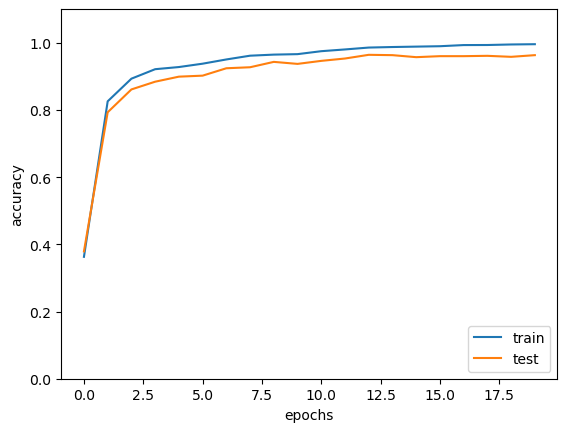

In [22]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from deep_learning_from_scratch.dataset.mnist import load_mnist

(img_train, label_train), (img_test, label_test) = load_mnist(flatten=False)

img_train, label_train = img_train[:5000], label_train[:5000]  # 学習データを1000件に制限
img_test, label_test = img_test[:1000], label_test[:1000]  # テストデータを100件に制限

max_epochs = 20  # エポック数
train_size = img_train.shape[0]  # 学習データのサイズ
batch_size = 100  # バッチサイズ

network = SimpleConvNet(input_dim=(1, 28, 28),
                        conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100,
                        output_size=10,
                        weight_init_std=0.01)

# 損失関数の値を計算
optimizer = Adam(lr = 0.001)

train_loss_list = []  # 学習時の損失関数の値を格納
train_acc_list = []  # 学習時の精度を格納するリスト
test_acc_list = []  # テスト時の精度を格納するリスト

iter_per_epoch = max(train_size // batch_size, 1)
epoch_cnt = 0

for i in range(10000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = img_train[batch_mask]
    t_batch = label_train[batch_mask]
    # print(x_batch.shape)
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:  # エポック数を更新
        train_acc = network.accuracy(img_train, label_train)  # 学習データに対する精度を計算
        test_acc = network.accuracy(img_test, label_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        print(f"Epoch: {epoch_cnt}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
        if epoch_cnt >= max_epochs:  # 最大エポック数に達したら終了
            break

x = np.arange(len(test_acc_list))
plt.plot(x, train_acc_list, label='train')
plt.plot(x, test_acc_list, label='test')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.show() 

- SimpleConvNetでMNISTデータセットを学習
    - 結果：
        - 訓練データの認識：0.9858
        - テストデータの認識：0.9490
        - とても認識制度が高い

# CNNの可視化

## １層目の重みの可視化
- 1層目の畳み込み層の重みの形状（30, 1, 5, 5）
    - サイズ：(5, 5)
    - チャンネル：1
    - フィルター数：30個
- フィルターサイズが5x5でチャンネルが1ということは、フィルターは１チェンネルのグレー画像として可視化できる！

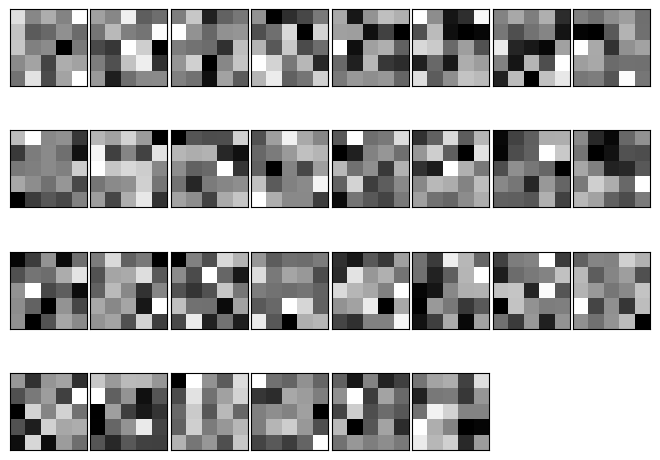

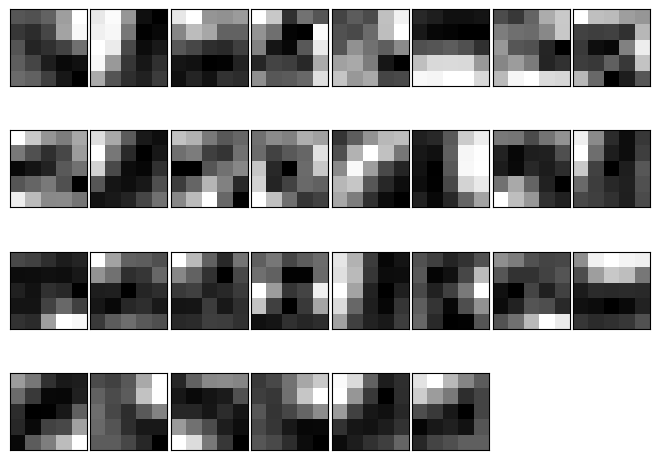

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network_new = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network_new.params['W1'])

# 学習後の重み
filter_show(network.params['W1'])

- 学習前
    - フィルターはランダムに初期化されているので、濃淡には規則性がない
- 学習後
    - フィルターは濃淡に規則性がある
    - 白から黒へグラデーションを伴って変化するフィルター
    - 塊のある領域（ブロブ）を持つフィルター
- 学習によって規則性のあるフィルターへと更新

- フィルターは「何を見ている」の？
    - エッジ（色が変化する境目）やブロブ（局所的に塊のある領域）
    - 左半分が白、右半分が黒のフィルターの場合
        - 縦方向のエッジに反応する
    - 上半分が黒、右半分が白のフィルターの場合
        - 横方向のエッジに反応する

## 階層構造による情報抽出
- これまでの結果：
    - １層目の畳み込み層を対象（`W1`）
    - エッジやブロブなどの**低レベルな情報が抽出**
- 何層にも重ねたCNNでは、各層どのような情報が抽出されるの？
    - 層が深くなるにしたがって、抽出される情報（正確には強く反応するニューロン）はより**抽象化されていく**
- 一般物体認識（車や犬など）を行う８層のCNNを例に考える(`AlexNet`)
    - 構造
        - 畳み込み層とプーリング層が何層にも重なっている
        - 最後に全結合層を経て結果が出力
    - 畳み込み層を何層も重ねると、**層が深くなるにつれてより複雑で抽象化された情報が抽出**できる
        - 最初の層：単純なエッジ（縦や横）に反応
        - 中間（1）の層：テクスチャなどに反応
        - 中間（2）の層：より複雑な物体のパーツに反応
        - 最後の層：物体のクラス
    - モノの「意味」を理解できるように、反応する対象が変化していく

# 代表的なCNN

## LeNet
> **LeNet**<br>
> 手書き認識を行うネットワークとして、1998念に初めて提案されたCNNの元祖
- 畳み込み層とプーリング層（正確には要素を間引くだけのサブサンプリング層）を連続して行い、全結合層を経て結果が出力
- 活性化関数は、シグモイド関数（現在の主流はReLU）

## AlexNet
> **AlexNet**<br>
> ディープラーニング・ブームの火つけ役になった<br>
> 畳み込み層とプーリング層を重ねて、最後に全結合層を経由して結果を出力
- LeNetとの違い
    - 活性化関数に**ReLU**を用いる
    - LRNという局所的な正則化を行う層を用いる
    - Dropout(**ニューロンをランダムに削除**しながら学習する手法)を使用する